In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
#style.use('seaborn-whitegrid')
style.use("seaborn-white")
plt.rcParams["figure.figsize"] = (10,6)

# Weekly Tasks
Prepare a presentation using Panopto (PowerPoint slides with Video Narration is an acceptable alternative) addressing the following points:
What scenario were you assigned as the result of the random number exercise?

- What were your considerations in determining an appropriate investment strategy for that scenario?

- What asset allocation did you implement that you felt best supported that investment strategy?

- What assets did you invest in consistent with that asset allocation and strategy? (Assets, Price at time of investment, % of total investment)

- Present Value, Profit/Loss to date, VaR, SHARPE, VWAP, Alpha (Other metrics that you feel important in support of your strategy) for your portfolio 

What reallocation of assets would you recommend at this time (if any) and why?
Post your presentation accessible to your colleagues for comment and comment on the presentations by your colleagues.

# Variables

In [2]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2023, 9, 11)
purchase_date_str = '2023-9-11'
end_date = datetime.now()
end_date_str = end_date.strftime("%Y-%m-%d")

alpha = 0.05
period = '5y'

# Functions

In [3]:
def alpha(portfolio_returns, benchmark_returns):
    # mean of the return
    portfolio_avg_return = np.mean(portfolio_returns)
    benchmark_avg_return = np.mean(benchmark_returns)
    
    # volatility
    portfolio_volatility = np.std(portfolio_returns)
    benchmark_volatility = np.std(benchmark_returns)
    
    # our alpha
    alpha = (portfolio_avg_return - benchmark_avg_return) / (portfolio_volatility / benchmark_volatility)
    
    return alpha


def linreg(x,y):
    x = sm.add_constant(x) # add a column of 1s to our data (for intercept)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1] # remove the constant
    return model.params[0], model.params[1]

# Load Data

## Load Variables

In [4]:
var_lst = ['GSPCX']
bench_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_df = pd.DataFrame(bench_df)
bench_df.columns = ['GSPCX']

benchPercent_df = bench_df.pct_change()[1:]
benchPercent_df.reset_index(inplace=True)
benchPercent_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,GSPCX
0,2023-09-12,-0.0066
1,2023-09-13,0.0000
2,2023-09-14,0.0067
3,2023-09-15,-0.0110
4,2023-09-18,0.0000


In [5]:
var_lst = ['GSPCX']
bench_econ_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_econ_df = round((bench_econ_df.mean() / 100),4)
bench_econ_df = pd.DataFrame(bench_econ_df)
bench_econ_df.columns = ['GSPCX']

benchPercent_econ_df = bench_econ_df.pct_change()[1:]
benchPercent_econ_df.reset_index(inplace=True)
benchPercent_econ_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,GSPCX
0,2023-09-12,-0.0066
1,2023-09-13,0.0000
2,2023-09-14,0.0067
3,2023-09-15,-0.0110
4,2023-09-18,0.0000


In [6]:
var_lst = ['AGG']
bench_int_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_int_df = round((bench_int_df.mean() / 100),4)
bench_int_df = pd.DataFrame(bench_int_df)
bench_int_df.columns = ['AGG']

benchPercent_int_df = bench_int_df.pct_change()[1:]
benchPercent_int_df.reset_index(inplace=True)
benchPercent_int_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,AGG
0,2023-09-12,0.0003
1,2023-09-13,0.0015
2,2023-09-14,-0.0014
3,2023-09-15,-0.0023
4,2023-09-18,0.0015


In [7]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w7/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })

folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class','Sub_Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)

# calculate portfilio percentage
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000.0000",0.0120
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.0000",500.0000,0.0060
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.0000",750.0000,0.0090
3,C_A_S_H,Cash,Cash,Cash,"4,182,856.0000","4,183.0000",0.0501
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,250.0000",0.0270
5,FREL,Fidelity MSCI Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"115,479.0000","2,800.0000",0.0336
6,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,"120,705.0000","4,000.0000",0.0479
7,GARIX,Gotham Absolute Return Institutional,Economically Sensitive,Long/Short Equities,"25,278.0000",500.0000,0.0060
8,GCHDX,Gotham Hedged Core Institutional,Economically Sensitive,Long/Short Equities,"46,211.0000",500.0000,0.0060
9,ICBFX,Invesco Corporate Bond R6,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"166,389.0000","1,000.0000",0.0120


In [8]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,183.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


In [9]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83433000.0

# 4. Portfolio

## 4.1 Load Pricing Time Series

In [10]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))

# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(ticker_lst, start=purchase_date, end=end_date)['Close']
price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
return_df.fillna(0, inplace=True)
return_df.index = pd.to_datetime(return_df.index)
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')



price_df #: (64, 35)
return_df #: 35


## 4.2 Portfolio Returns

In [11]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

return_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_df #:', return_df.shape)

port_ret_weighted #: (64, 35)
return_df #: (64, 36)


In [12]:
weight_lst

array([0.01198567, 0.00599283, 0.00898925, 0.05013604, 0.02696775,
       0.03355986, 0.04794266, 0.00599283, 0.00599283, 0.01198567,
       0.06592116, 0.02397133, 0.04794266, 0.035957  , 0.04794266,
       0.04794266, 0.02996416, 0.01198567, 0.01198567, 0.01198567,
       0.05033979, 0.01198567, 0.01198567, 0.035957  , 0.01198567,
       0.07191399, 0.01198567, 0.06592116, 0.01198567, 0.02397133,
       0.035957  , 0.03895341, 0.02397133, 0.035957  , 0.01198567])

# 5. Calculate Portfolio Value

In [13]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
shares_df.head()

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,182,856.0000"
DFAR,"108,467.0000"


In [14]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

,Date,Ticker,Price
0,2023-09-11,ALTVX,9.4000
1,2023-09-12,ALTVX,9.3900
2,2023-09-13,ALTVX,9.3900
3,2023-09-14,ALTVX,9.3800
4,2023-09-15,ALTVX,9.3800


In [15]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

l_df:  (35, 3)


In [16]:
merge_df = m_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker').merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')
merge_df['share_value'] = merge_df['Price'] * merge_df['Shares']
merge_df['pct_share_value'] = merge_df.groupby(['Ticker'])[['share_value']].pct_change()

print('merge_df: ',merge_df.shape)

merge_df:  (2240, 8)


In [17]:
merge_df

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,pct_share_value
0,2023-09-11,ALTVX,9.4000,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000,000.1594",NaN
1,2023-09-12,ALTVX,9.3900,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","998,936.4065",-0.0011
2,2023-09-13,ALTVX,9.3900,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","998,936.4065",0.0000
3,2023-09-14,ALTVX,9.3800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","997,872.5522",-0.0011
4,2023-09-15,ALTVX,9.3800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","997,872.5522",0.0000
...,...,...,...,...,...,...,...,...
2235,2023-12-04,VTEB,50.1100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","1,018,886.6424",-0.0008
2236,2023-12-05,VTEB,50.2300,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","1,021,326.5807",0.0024
2237,2023-12-06,VTEB,50.2800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","1,022,343.2152",0.0010
2238,2023-12-07,VTEB,50.3100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","1,022,953.2579",0.0006


In [18]:
m_df = merge_df[['Date','Ticker','share_value']]

#m_df.reset_index(inplace=True)
#m_df = m_df.pivot(index=['Date'], columns=['Ticker'])['share_value']
m_df = m_df.pivot(index=['Date'], columns=['Ticker'])['share_value']
m_df.head()

Ticker,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,GARIX,GCHDX,ICBFX,...,SWRSX,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-11,"1,000,000.1594","500,017.1970","750,004.6814","4,182,856.0000","2,273,468.2207","2,825,771.0507","4,014,648.0974","499,998.8574","500,003.0059","999,997.9281",...,"5,999,999.0678","1,005,393.5925","5,499,996.4816","1,000,007.7357","1,999,994.5866","3,007,333.5271","3,281,631.2427","2,007,286.9651","3,005,502.3440","999,976.9462"
2023-09-12,"998,936.4065","498,171.1060","748,505.6371","4,182,856.0000","2,277,807.0000","2,828,080.6836","4,007,406.0921","496,965.4761","495,844.0088","1,001,661.7768",...,"6,005,922.2034","1,007,474.3701","5,499,996.4816","1,000,007.7357","1,999,994.5866","2,995,998.8965","3,280,022.6727","2,003,408.7020","2,970,226.5573","999,163.6076"
2023-09-13,"998,936.4065","499,023.1313","746,007.3252","4,182,856.0000","2,256,113.5172","2,795,746.4843","3,986,886.0027","496,712.6904","495,844.0088","1,001,661.7768",...,"6,011,844.7741","1,000,191.5552","5,505,660.8713","1,001,096.3968","2,001,913.0905","2,990,736.1688","3,244,226.0073","1,992,604.7980","2,981,016.9060","999,773.5728"
2023-09-14,"997,872.5522","500,443.2638","753,002.6748","4,182,856.0000","2,299,500.4828","2,848,866.9388","4,036,375.0342","498,734.9284","498,154.5677","999,997.9281",...,"5,999,999.0678","1,015,002.0374","5,499,996.4816","1,001,096.3968","1,999,994.5866","3,017,858.6735","3,302,948.6305","2,012,273.2631","3,000,107.3280","998,960.3117"
2023-09-15,"997,872.5522","499,307.1578","750,004.6814","4,182,856.0000","2,292,992.3138","2,810,758.8776","3,983,265.0000","492,921.0000","492,609.2529","998,334.0000",...,"5,988,152.7966","1,006,801.1664","5,483,003.8529","998,918.9708","1,996,157.5788","3,012,191.3582","3,290,479.9118","1,995,005.7282","2,952,796.2133","997,333.6345"


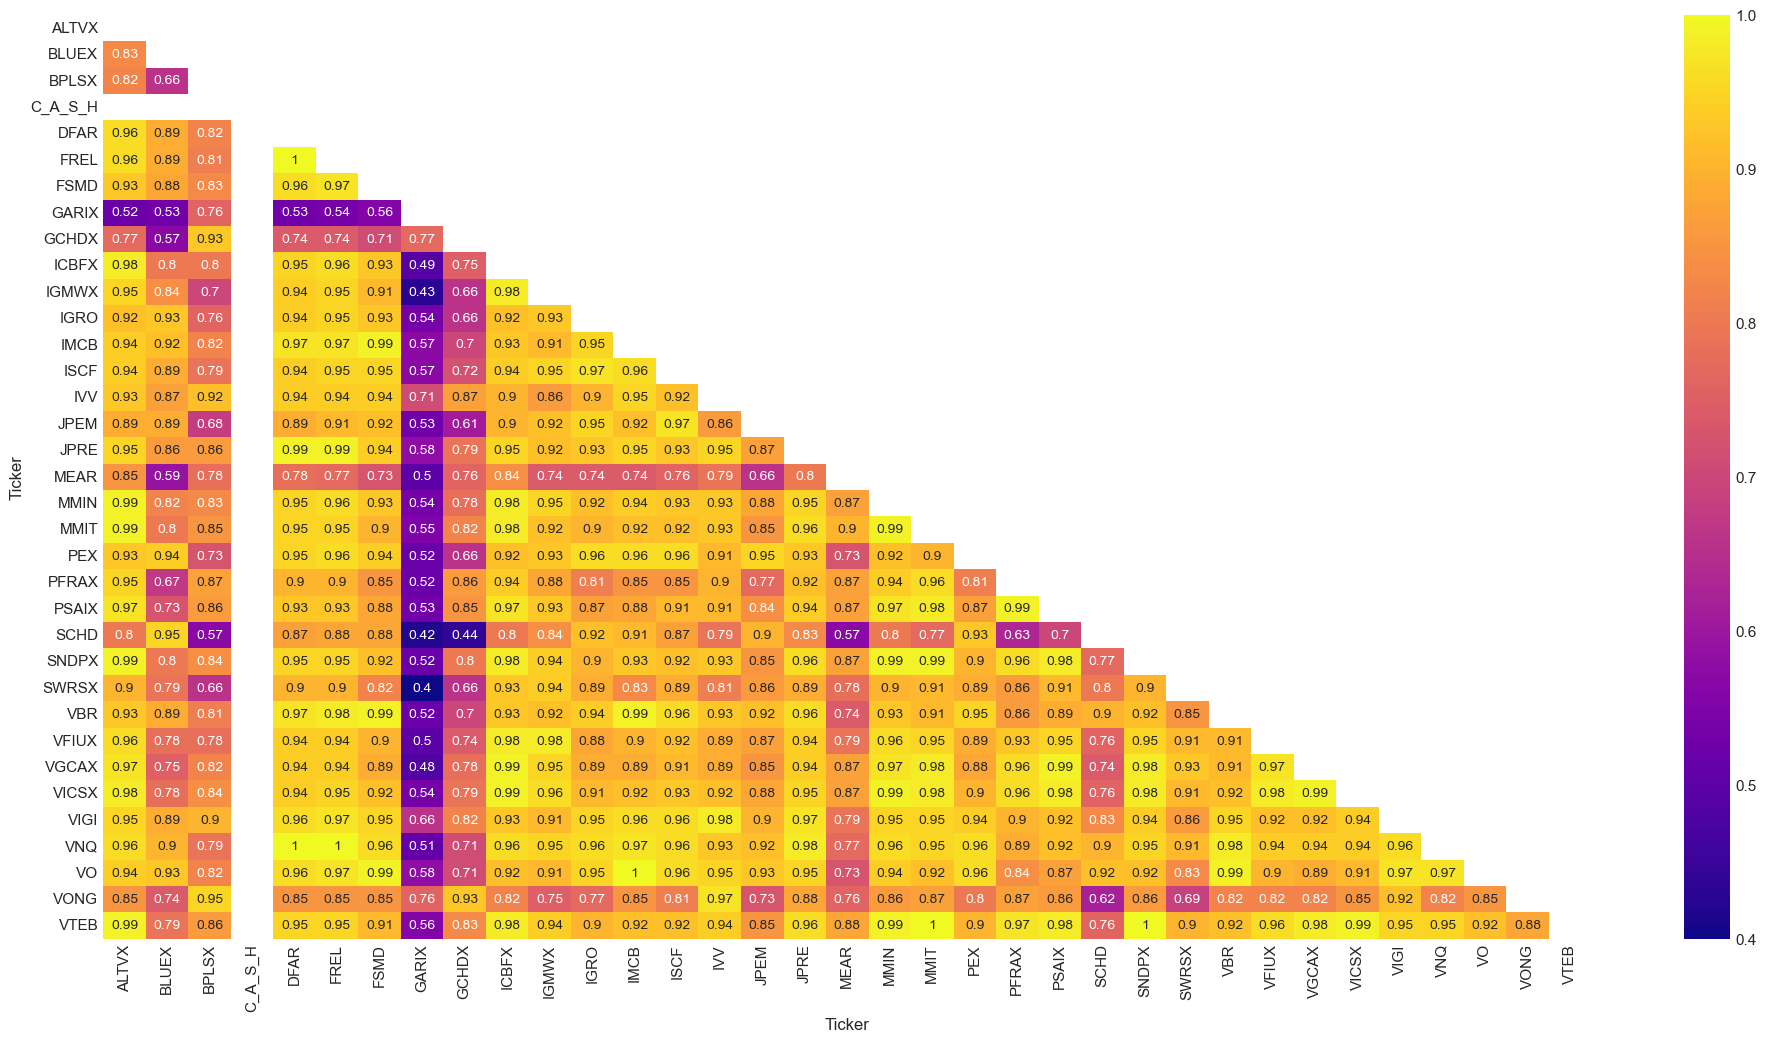

In [19]:
plt.figure(figsize=(24,12))
mask = np.zeros_like(m_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(m_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

In [20]:
folioValue_df = merge_df.groupby(['Date'])[['share_value']].sum().reset_index()
folioValue_df['pct_change'] = folioValue_df['share_value'].pct_change()

print('folioValue_df: ',folioValue_df.shape)

folioValue_df:  (64, 3)


In [21]:
fv_df = merge_df.groupby(['Date','Class'])[['share_value']].sum().reset_index()
fv_df['pct_change'] = fv_df.groupby(['Class'])[['share_value']].pct_change()

print('folioValue_df: ',fv_df.shape)

folioValue_df:  (192, 4)


## 5.1 Portfolio Value

In [22]:
folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000.0000",0.0120
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.0000",500.0000,0.0060
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.0000",750.0000,0.0090
3,C_A_S_H,Cash,Cash,Cash,"4,182,856.0000","4,183.0000",0.0501
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,250.0000",0.0270
5,FREL,Fidelity MSCI Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"115,479.0000","2,800.0000",0.0336
6,FSMD,Fidelity Small-Mid Multifactor ETF,Economically Sensitive,U.S. Equities,"120,705.0000","4,000.0000",0.0479
7,GARIX,Gotham Absolute Return Institutional,Economically Sensitive,Long/Short Equities,"25,278.0000",500.0000,0.0060
8,GCHDX,Gotham Hedged Core Institutional,Economically Sensitive,Long/Short Equities,"46,211.0000",500.0000,0.0060
9,ICBFX,Invesco Corporate Bond R6,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,"166,389.0000","1,000.0000",0.0120


In [23]:
folio_df.groupby(['Class','Sub_Class'])[['Value']].sum()

Value
Class                   Sub_Class                                    
Cash                    Cash                               4,183.0000
Economically Sensitive  Emerging Market Equities           4,000.0000
                        International Equities             8,000.0000
                        Long/Short Equities                2,250.0000
                        Private Equity                     4,200.0000
                        Publicly Traded REITs             10,800.0000
                        U.S. Equities                     21,000.0000
Interest Rate Sensitive U.S. Government Bonds             17,000.0000
                        Very-High-Quality Corporate Bonds  6,000.0000
                        Very-High-Quality Municipal Bonds  6,000.0000

In [24]:
folio_df[['Value']].sum()

Value   83,433.0000
dtype: float64

## Graph Porfolio Values

In [25]:
r1_df = folioValue_df.loc[(folioValue_df['Date'] == min(folioValue_df['Date']))
                     | (folioValue_df['Date'] == max(folioValue_df['Date']))]
print('Portfolio Return: ',r1_df['share_value'].pct_change()[-1:].values)
r1_df

Portfolio Return:  [0.01387715]


,Date,share_value,pct_change
0,2023-09-11,"83,718,683.5760",NaN
63,2023-12-08,"84,880,460.0098",0.0002


In [26]:
r1_df = bench_df.loc[(bench_df.index == min(bench_df.index))
                     | (bench_df.index == max(bench_df.index))]
print('Benchmark Return: ',r1_df['GSPCX'].pct_change()[-1:].values)
r1_df

Benchmark Return:  [0.02720587]


,GSPCX
Date,
2023-09-11,13.6000
2023-12-08,13.9700


In [27]:
m1_df = folioValue_df.merge(benchPercent_df, how='outer', left_on='Date', right_on='Date')
m1_df['date_str'] = m1_df['Date'].dt.strftime('%b-%d')
m1_df.head()

,Date,share_value,pct_change,GSPCX,date_str
0,2023-09-11,"83,718,683.5760",NaN,NaN,Sep-11
1,2023-09-12,"83,597,204.6712",-0.0015,-0.0066,Sep-12
2,2023-09-13,"83,425,622.0770",-0.0021,0.0000,Sep-13
3,2023-09-14,"83,951,847.4157",0.0063,0.0067,Sep-14
4,2023-09-15,"83,535,984.2190",-0.0050,-0.0110,Sep-15


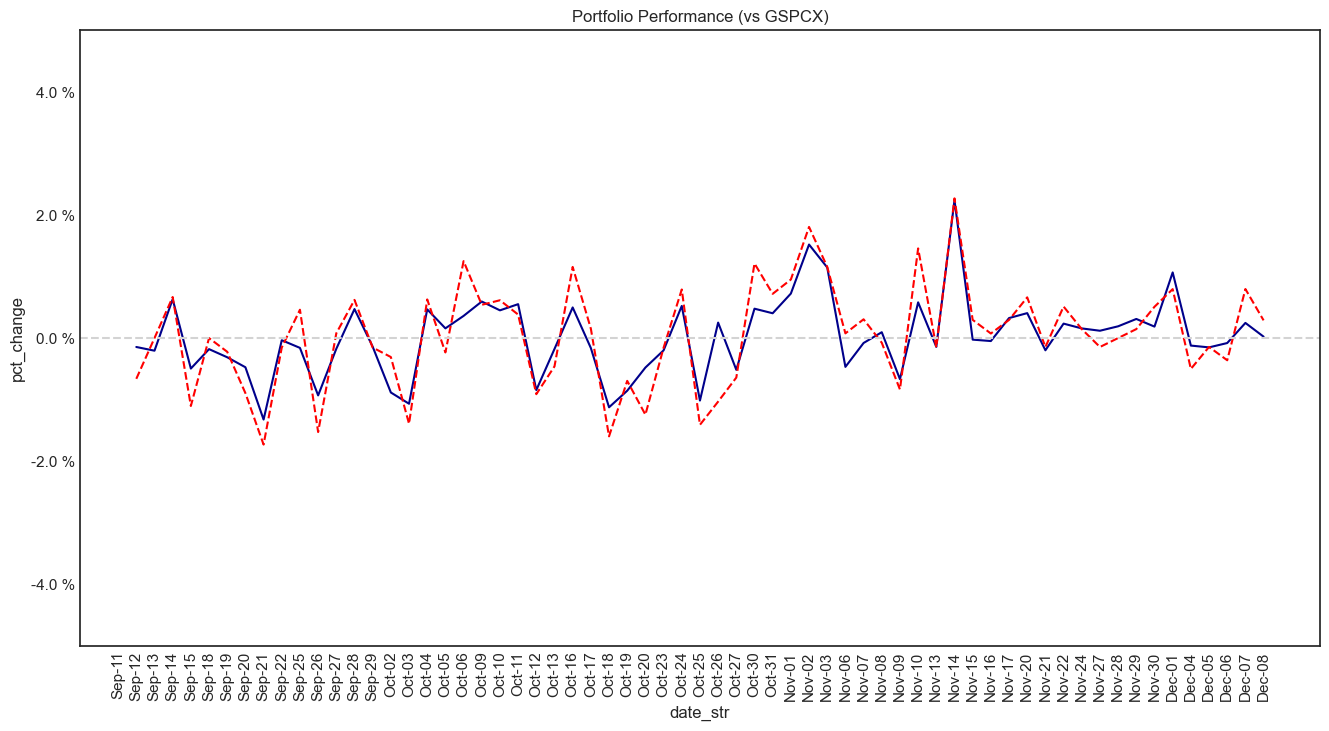

In [28]:
# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

ax.set_ylim(-.05, 0.05)
ax.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['date_str'].tolist()
#ax.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# Plot
sns.set_style("white")
g = sns.lineplot(data=m1_df, x="date_str", y="pct_change", color='darkblue')
g = sns.lineplot(data=m1_df, x="date_str", y="GSPCX", color='red', linestyle="dashed")
#ax = sns.lineplot(x=x, y=y, linestyle="dashed")
g.set_yticklabels(['{:,.1f}'.format(x) + ' %' for x in g.get_yticks() * 100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax.set(title='Portfolio Performance (vs GSPCX)');

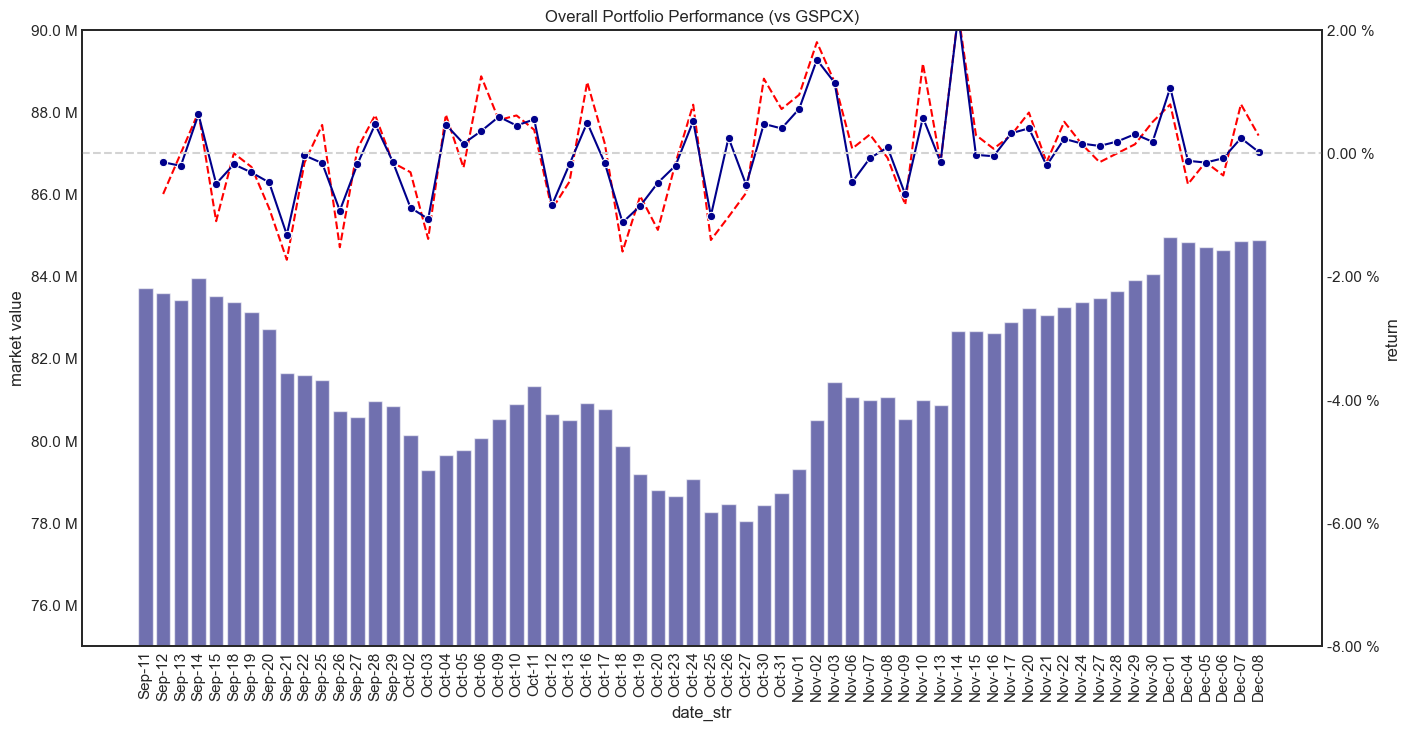

In [29]:
fig, ax1 = plt.subplots(figsize=(16,8))

sns.barplot(data = m1_df, x='date_str', y='share_value', alpha=0.60, color='darkblue',  ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(color='red' , linestyle="dashed" ,sort=False, data = m1_df, x='date_str',y ='GSPCX',dashes=True, ax=ax2)
sns.lineplot(color='darkblue' , marker='o' ,sort=False, data = m1_df, x='date_str', y='pct_change',ax=ax2)


ax1.set_ylim(75000000, 90000000)
ax2.set_ylim(-.08, 0.02)

ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['date_str'].tolist()
#ax1.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])
ax1.set_yticklabels(['{:,.1f}'.format(y) + ' M' for y in ax1.get_yticks()/1000000])
ax2.set_yticklabels(['{:,.2f}'.format(y) + ' %' for y in ax2.get_yticks()*100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

# annotations
ax2.set_title('Overall Portfolio Performance (vs GSPCX)')
ax2.set(xlabel='month', ylabel='return')
ax1.set(ylabel='market value')

plt.show()

### Economically Sensitive

In [30]:
t_df = fv_df[fv_df['Class'] == 'Economically Sensitive']
t_df = t_df.merge(benchPercent_econ_df, how='outer', left_on='Date', right_on='Date')
t_df['date_str'] = t_df['Date'].dt.strftime('%b-%d')
t_df.head()

,Date,Class,share_value,pct_change,GSPCX,date_str
0,2023-09-11,Economically Sensitive,"50,535,872.6588",NaN,NaN,Sep-11
1,2023-09-12,Economically Sensitive,"50,401,357.6570",-0.0027,-0.0066,Sep-12
2,2023-09-13,Economically Sensitive,"50,201,477.5737",-0.0040,0.0000,Sep-13
3,2023-09-14,Economically Sensitive,"50,758,492.1692",0.0111,0.0067,Sep-14
4,2023-09-15,Economically Sensitive,"50,399,819.5650",-0.0071,-0.0110,Sep-15


In [31]:
r1_df = t_df.loc[(t_df['Date'] == min(t_df['Date']))
                     | (t_df['Date'] == max(t_df['Date']))]
print('Economically Class Return: ',r1_df['share_value'].pct_change()[-1:].values)
r1_df

Economically Class Return:  [0.01664019]


,Date,Class,share_value,pct_change,GSPCX,date_str
0,2023-09-11,Economically Sensitive,"50,535,872.6588",NaN,NaN,Sep-11
63,2023-12-08,Economically Sensitive,"51,376,799.2009",0.0018,0.0029,Dec-08


In [32]:
r1_df = bench_df.loc[(bench_econ_df.index == min(bench_econ_df.index))
                     | (bench_econ_df.index == max(bench_econ_df.index))]
print('Benchmark Return: ',r1_df['GSPCX'].pct_change()[-1:].values)

Benchmark Return:  [0.02720587]


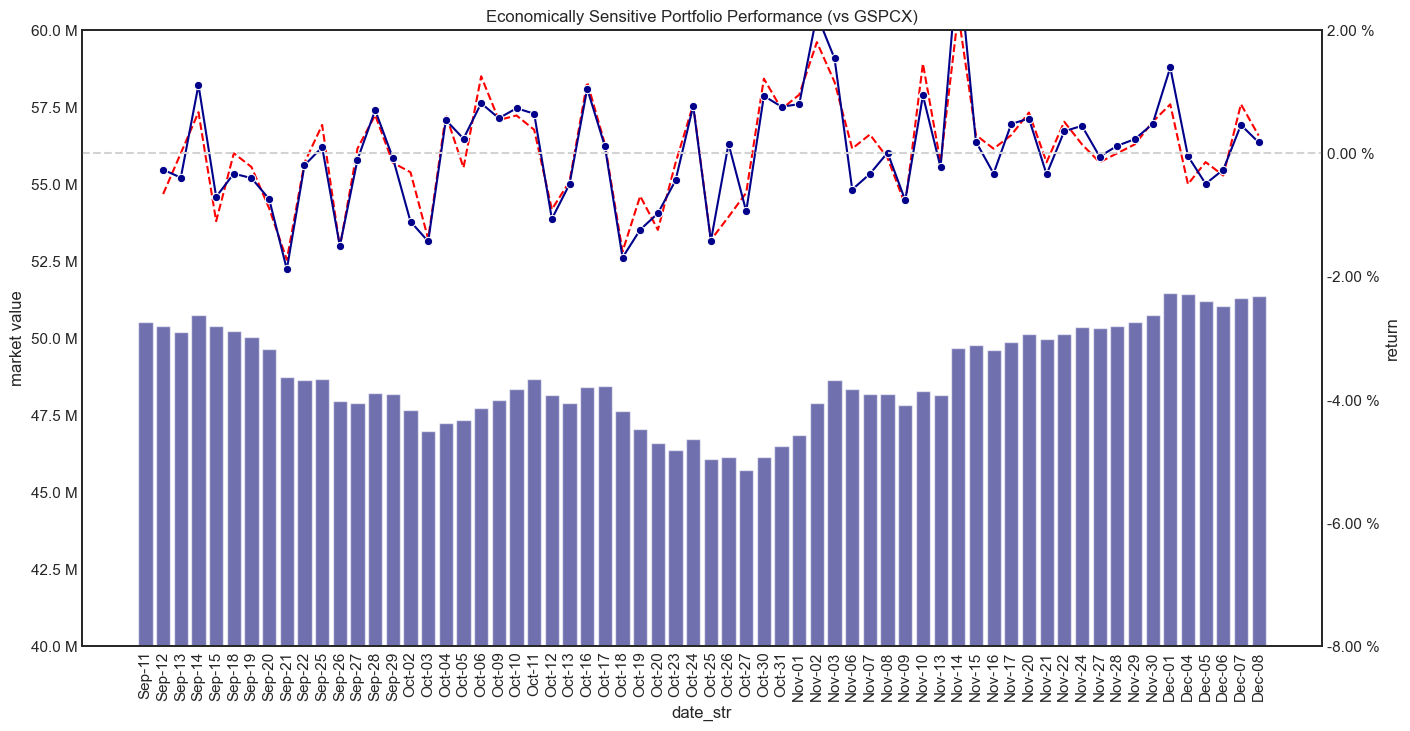

In [33]:
fig, ax1 = plt.subplots(figsize=(16,8))

sns.barplot(data = t_df, x='date_str', y='share_value', alpha=0.60, color='darkblue',  ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(color='red' , linestyle="dashed" ,sort=False, data = t_df, x='date_str',y ='GSPCX',dashes=True, ax=ax2)
sns.lineplot(color='darkblue' , marker='o' ,sort=False, data = t_df, x='date_str', y='pct_change',ax=ax2)


ax1.set_ylim(40000000, 60000000)
ax2.set_ylim(-.08, 0.02)

ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = t_df['date_str'].tolist()
#ax1.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])
ax1.set_yticklabels(['{:,.1f}'.format(y) + ' M' for y in ax1.get_yticks()/1000000])
ax2.set_yticklabels(['{:,.2f}'.format(y) + ' %' for y in ax2.get_yticks()*100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

# annotations
ax2.set_title('Economically Sensitive Portfolio Performance (vs GSPCX)')
ax2.set(xlabel='month', ylabel='return')
ax1.set(ylabel='market value')

plt.show()

### Interest Sensitive

In [34]:
t_df = fv_df[fv_df['Class'] == 'Interest Rate Sensitive']
t_df = t_df.merge(benchPercent_int_df, how='outer', left_on='Date', right_on='Date')
t_df['date_str'] = t_df['Date'].dt.strftime('%b-%d')
t_df.head()

,Date,Class,share_value,pct_change,AGG,date_str
0,2023-09-11,Interest Rate Sensitive,"28,999,954.9171",NaN,NaN,Sep-11
1,2023-09-12,Interest Rate Sensitive,"29,012,991.0141",0.0004,0.0003,Sep-12
2,2023-09-13,Interest Rate Sensitive,"29,041,288.5032",0.0010,0.0015,Sep-13
3,2023-09-14,Interest Rate Sensitive,"29,010,499.2465",-0.0011,-0.0014,Sep-14
4,2023-09-15,Interest Rate Sensitive,"28,953,308.6540",-0.0020,-0.0023,Sep-15


In [35]:
r1_df = t_df.loc[(t_df['Date'] == min(t_df['Date']))
                     | (t_df['Date'] == max(t_df['Date']))]
print('Interest Class Return: ',r1_df['share_value'].pct_change()[-1:].values)

Interest Class Return:  [0.01106381]


In [36]:
r1_df = bench_int_df.loc[(bench_int_df.index == min(bench_int_df.index))
                     | (bench_int_df.index == max(bench_int_df.index))]
print('Benchmark Return: ',r1_df['AGG'].pct_change()[-1:].values)

Benchmark Return:  [0.01275218]


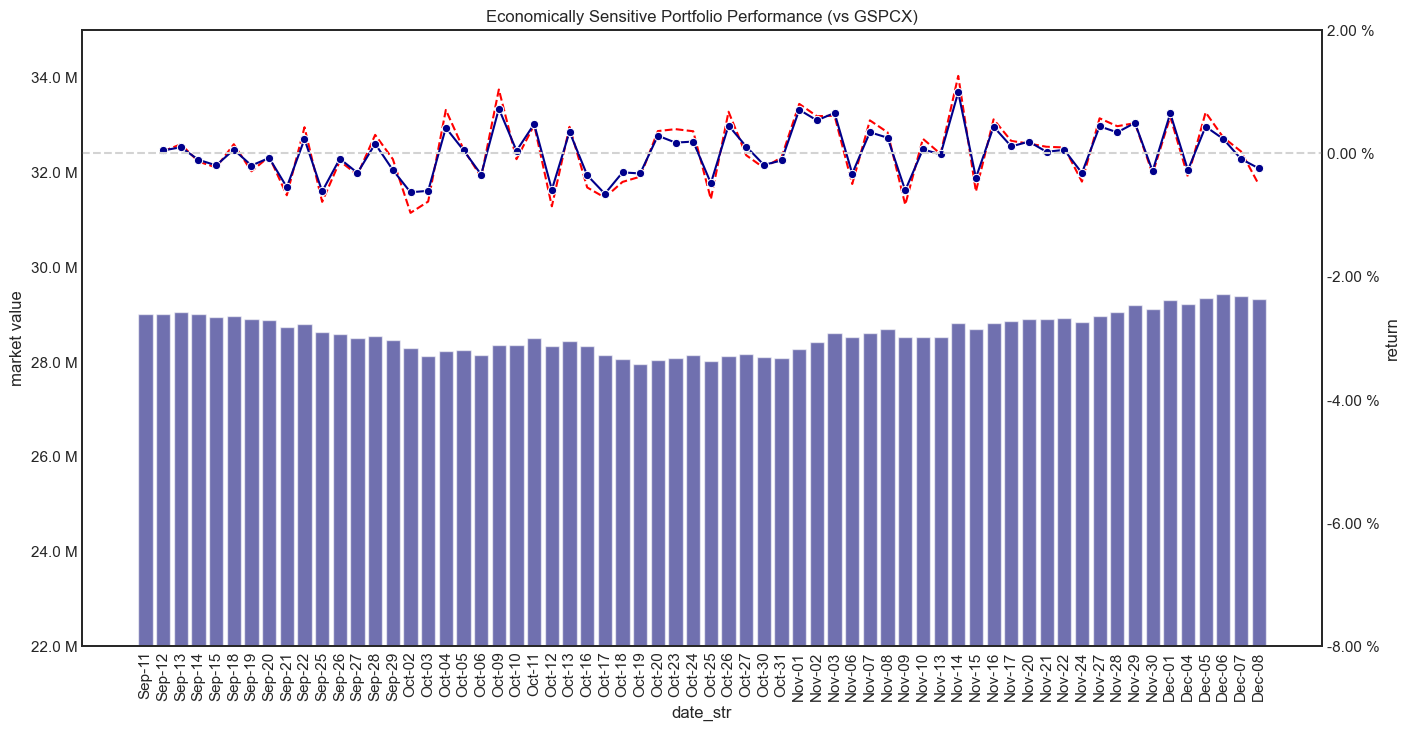

In [37]:
fig, ax1 = plt.subplots(figsize=(16,8))

sns.barplot(data = t_df, x='date_str', y='share_value', alpha=0.60, color='darkblue',  ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(color='red' , linestyle="dashed" ,sort=False, data = t_df, x='date_str',y ='AGG',dashes=True, ax=ax2)
sns.lineplot(color='darkblue' , marker='o' ,sort=False, data = t_df, x='date_str', y='pct_change',ax=ax2)


ax1.set_ylim(22000000, 35000000)
ax2.set_ylim(-.08, 0.02)

ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = t_df['date_str'].tolist()
#ax1.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])
ax1.set_yticklabels(['{:,.1f}'.format(y) + ' M' for y in ax1.get_yticks()/1000000])
ax2.set_yticklabels(['{:,.2f}'.format(y) + ' %' for y in ax2.get_yticks()*100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

# annotations
ax2.set_title('Economically Sensitive Portfolio Performance (vs GSPCX)')
ax2.set(xlabel='month', ylabel='return')
ax1.set(ylabel='market value')

plt.show()

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data = m2_df,x='Date',y='pct_change', color='red' , linestyle="dashed" ,sort=False, ax=ax)
sns.lineplot(data = t_df,x='Date',y='pct_change', marker='o' ,color='darkblue',sort=True, ax=ax)
plt.show()

t_df[['Date','pct_change']]

fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()

#sns.lineplot(data = t_df[['Date','pct_change']], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = t_df, x='Date', y='pct_change', marker='o' ,color='darkblue',sort=True, ax=ax1)
#sns.lineplot(data = m2_df['GSPCX'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
sns.lineplot(data = m2_df,x='Date',y='pct_change', color='red' , linestyle="dashed" ,sort=True, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')


#sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)
sns.barplot(data = t_df, x='Date', y='share_value',errorbar=None,alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.15, 0.05)
ax2.set_ylim(40000000, 60000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])


ax1.set_title('Economically Sensitive Portfolio Performance (vs GSPCX)')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

In [38]:
t_df = fv_df[fv_df['Class'] == 'Interest Rate Sensitive']
t_df = fv_df.merge(benchPercent_int_df, how='outer', left_on='Date', right_on='Date')
t_df.head()

,Date,Class,share_value,pct_change,AGG
0,2023-09-11,Cash,"4,182,856.0000",NaN,NaN
1,2023-09-11,Economically Sensitive,"50,535,872.6588",NaN,NaN
2,2023-09-11,Interest Rate Sensitive,"28,999,954.9171",NaN,NaN
3,2023-09-12,Cash,"4,182,856.0000",0.0000,0.0003
4,2023-09-12,Economically Sensitive,"50,401,357.6570",-0.0027,0.0003


fig, ax1 = plt.subplots(figsize=(16,8))
sns.lineplot(data = t_df['pct_change'], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = benchPercent_int_df['AGG'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax2 = ax1.twinx()
#sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)
sns.barplot(data = t_df, x='Date', y='share_value',errorbar=None,alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.08, 0.02)
ax2.set_ylim(28000000, 30000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# annotations
ax1.set_title('Interest Rate Sensitive Portfolio Performance (vs AGG)')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

# Alpha Calculations

# Economically Sensitive

In [39]:
#tickers='^DJA'
#tickers = 'FHNFX'
tickers='GSPCX'
bench_data = pdr.get_data_yahoo(tickers=tickers, start=purchase_date, end=end_date )
bench_econ_df= pd.DataFrame(bench_data['Close'])
bench_econ_df.columns = ['bench']
bench_econ_df['precent_bench']= bench_econ_df['bench'].pct_change(1)

print('bench_econ_df:', bench_econ_df.shape)

[*********************100%%**********************]  1 of 1 completed
bench_econ_df: (64, 2)


In [40]:
# ticker symbols
ticker_lst = folio_econ_df['Ticker'].tolist()
print('econ ticker_lst:', len(ticker_lst))

# portfolio weights
weight_lst = (folio_econ_df['port_percent'].values)
print('weight_lst #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(tickers=ticker_lst, start=purchase_date, end=end_date)['Close']
#price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

econ ticker_lst: 20
weight_lst #: 20
[*********************100%%**********************]  20 of 20 completed
price_df #: (64, 20)


In [41]:
# Shares
shares_df = folio_df[['Ticker','Shares']]
#shares_df.set_index('Ticker', drop=True, inplace=True)
print('shares_df: ',shares_df.shape)

# Prices
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
print('m_df: ',m_df.shape)

# Asset Class
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

shares_df:  (35, 2)
m_df:  (1280, 3)
l_df:  (35, 3)


In [42]:
m1_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker').merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')
m1_df['share_value'] = m1_df['Price'] * m1_df['Shares']
m1_df['pct_share_value'] = m1_df.groupby(['Ticker'])[['share_value']].pct_change()

print('m1_df: ',m1_df.shape)

m1_df:  (1295, 8)


In [43]:
alpha_econ_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_econ_df['precent_bench'].values
    y = m1_df[m1_df['Ticker'] == t]['pct_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_econ_df.loc[len(alpha_econ_df.index)] = [t, alpha, beta]
    
print('alpha_econ_df:', alpha_econ_df.shape)
alpha_econ_df.head()

alpha_econ_df: (20, 3)


,Ticker,alpha,beta
0,BLUEX,-0.0005,0.6315
1,BPLSX,0.0003,0.5453
2,DFAR,0.0000,1.3082
3,FREL,-0.0001,1.3620
4,FSMD,0.0000,1.0606


## Graph

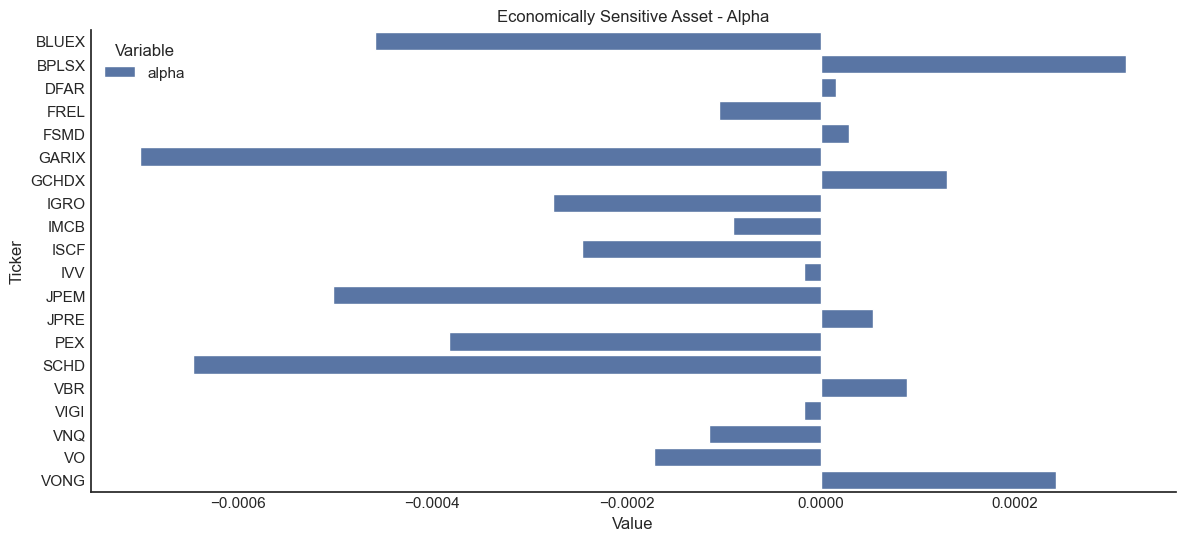

In [44]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Alpha');

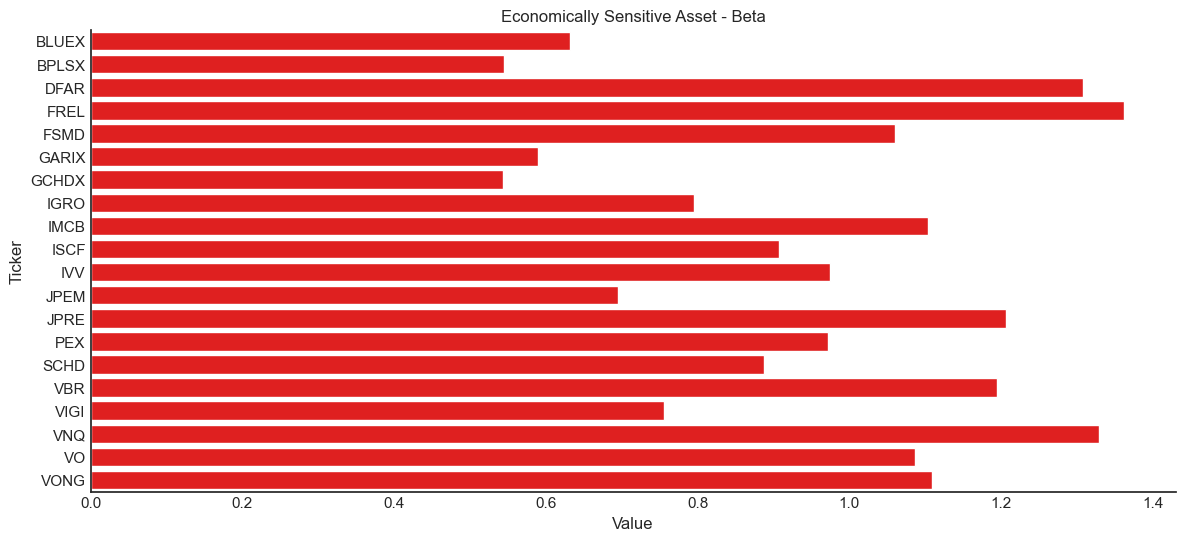

In [45]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red', data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Beta');

# Interest Rate Sensitive

In [46]:
#tickers='^DJA'
#tickers = 'FHNFX'
tickers = 'AGG'
bench_data = pdr.get_data_yahoo(tickers=tickers, start=purchase_date, end=end_date)
bench_int_df= pd.DataFrame(bench_data['Close'])
bench_int_df.columns = ['bench']
bench_int_df['precent_bench']= bench_int_df['bench'].pct_change(1)

print('bench_int_df #:', bench_int_df.shape)
lb = len(bench_int_df)

[*********************100%%**********************]  1 of 1 completed
bench_int_df #: (64, 2)


In [47]:
# ticker symbols
ticker_lst = folio_int_df['Ticker'].tolist()
print('econ ticker_lst:', len(ticker_lst))

# portfolio weights
weight_lst = (folio_int_df['port_percent'].values)
print('weight_lst #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(tickers=ticker_lst, start=purchase_date, end=end_date)['Close']
#price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

econ ticker_lst: 14
weight_lst #: 14
[*********************100%%**********************]  14 of 14 completed
price_df #: (64, 14)


In [48]:
# Shares
shares_df = folio_int_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
print('shares_df: ',shares_df.shape)

# Prices
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
print('m_df: ',m_df.shape)

# Asset Class
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

shares_df:  (14, 1)
m_df:  (896, 3)
l_df:  (35, 3)


In [49]:
m1_df = m_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker').merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')
m1_df['share_value'] = m1_df['Price'] * m1_df['Shares']
m1_df['pct_share_value'] = m1_df.groupby(['Ticker'])[['share_value']].pct_change()

print('m1_df: ',m1_df.shape)

m1_df:  (917, 8)


In [50]:
alpha_int_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_int_df['precent_bench'].values
    y = m1_df[m1_df['Ticker'] == t]['pct_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_int_df.loc[len(alpha_int_df.index)] = [t, alpha, beta]
    
print('alpha_int_df:', alpha_int_df.shape)
alpha_int_df.head()

alpha_int_df: (14, 3)


,Ticker,alpha,beta
0,ALTVX,0.0002,0.4338
1,ICBFX,0.0001,0.9981
2,IGMWX,-0.0001,1.0974
3,MEAR,0.0000,0.0079
4,MMIN,0.0002,0.7434


## Graph

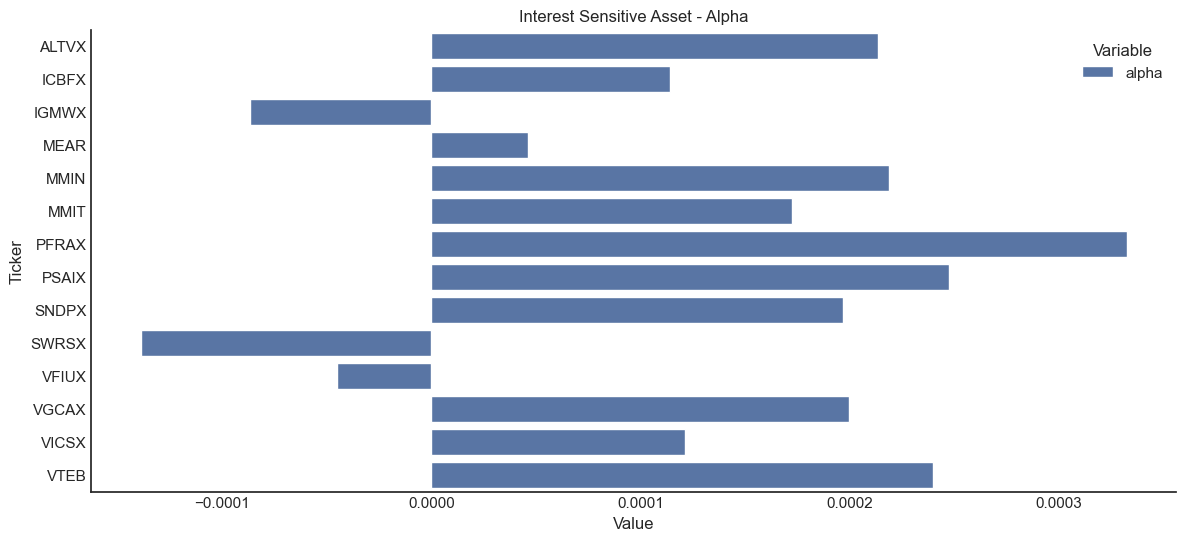

In [51]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Alpha');

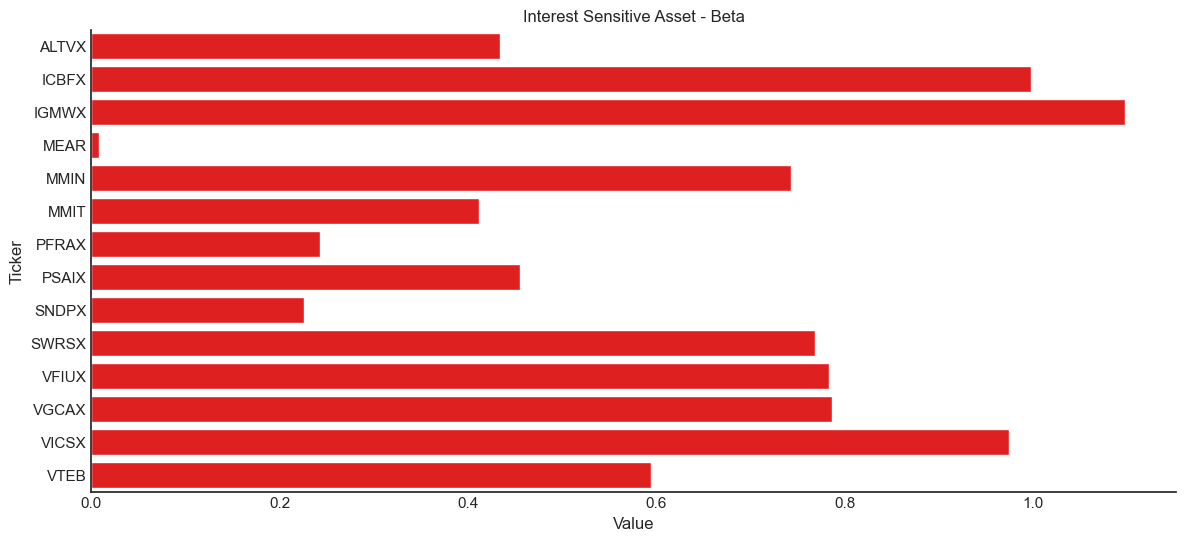

In [52]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Beta');

# Performance

In [53]:
f_df = merge_df.loc[(merge_df['Date'] == min(merge_df['Date']))
                     | (merge_df['Date'] == max(merge_df['Date']))]
f_df['pct_share_value'] = merge_df.groupby(['Ticker'])[['share_value']].pct_change()
f_df = f_df.loc[(f_df['Date'] == max(f_df['Date']))]

print('f_df: ', f_df.shape)
f_df.head()

f_df:  (35, 8)


,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,pct_share_value
63,2023-12-08,ALTVX,9.5800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,019,149.1319",-0.0010
127,2023-12-08,BLUEX,34.8000,Economically Sensitive,Long/Short Equities,"14,201.0000","494,194.7892",-0.0006
191,2023-12-08,BPLSX,15.5400,Economically Sensitive,Long/Short Equities,"49,967.0000","776,487.1781",0.0032
255,2023-12-08,C_A_S_H,1.0000,Cash,Cash,"4,182,856.0000","4,182,856.0000",0.0000
319,2023-12-08,DFAR,21.6500,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,348,310.5086",-0.0018


In [54]:
a_df = pd.concat([alpha_econ_df,alpha_int_df])
a_df.head()

,Ticker,alpha,beta
0,BLUEX,-0.0005,0.6315
1,BPLSX,0.0003,0.5453
2,DFAR,0.0000,1.3082
3,FREL,-0.0001,1.3620
4,FSMD,0.0000,1.0606


In [55]:
f1_df = f_df.merge(a_df, how='left', left_on='Ticker', right_on='Ticker') 
f1_df.fillna(0, inplace=True)
f1_df.head()

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,pct_share_value,alpha,beta
0,2023-12-08,ALTVX,9.5800,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,019,149.1319",-0.0010,0.0002,0.4338
1,2023-12-08,BLUEX,34.8000,Economically Sensitive,Long/Short Equities,"14,201.0000","494,194.7892",-0.0006,-0.0005,0.6315
2,2023-12-08,BPLSX,15.5400,Economically Sensitive,Long/Short Equities,"49,967.0000","776,487.1781",0.0032,0.0003,0.5453
3,2023-12-08,C_A_S_H,1.0000,Cash,Cash,"4,182,856.0000","4,182,856.0000",0.0000,0.0000,0.0000
4,2023-12-08,DFAR,21.6500,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,348,310.5086",-0.0018,0.0000,1.3082


In [56]:
long_df = f1_df[['Date','Ticker','Class','Sub_Class','pct_share_value','alpha','beta']].copy()
long_df= long_df[long_df['Class'] == 'Economically Sensitive']

long_df.reset_index(inplace=True, drop=True)
long_df = long_df.melt(id_vars=['Date','Ticker','Class','Sub_Class'])
long_df.head()

,Date,Ticker,Class,Sub_Class,variable,value
0,2023-12-08,BLUEX,Economically Sensitive,Long/Short Equities,pct_share_value,-0.0006
1,2023-12-08,BPLSX,Economically Sensitive,Long/Short Equities,pct_share_value,0.0032
2,2023-12-08,DFAR,Economically Sensitive,Publicly Traded REITs,pct_share_value,-0.0018
3,2023-12-08,FREL,Economically Sensitive,Publicly Traded REITs,pct_share_value,-0.0024
4,2023-12-08,FSMD,Economically Sensitive,U.S. Equities,pct_share_value,0.0041


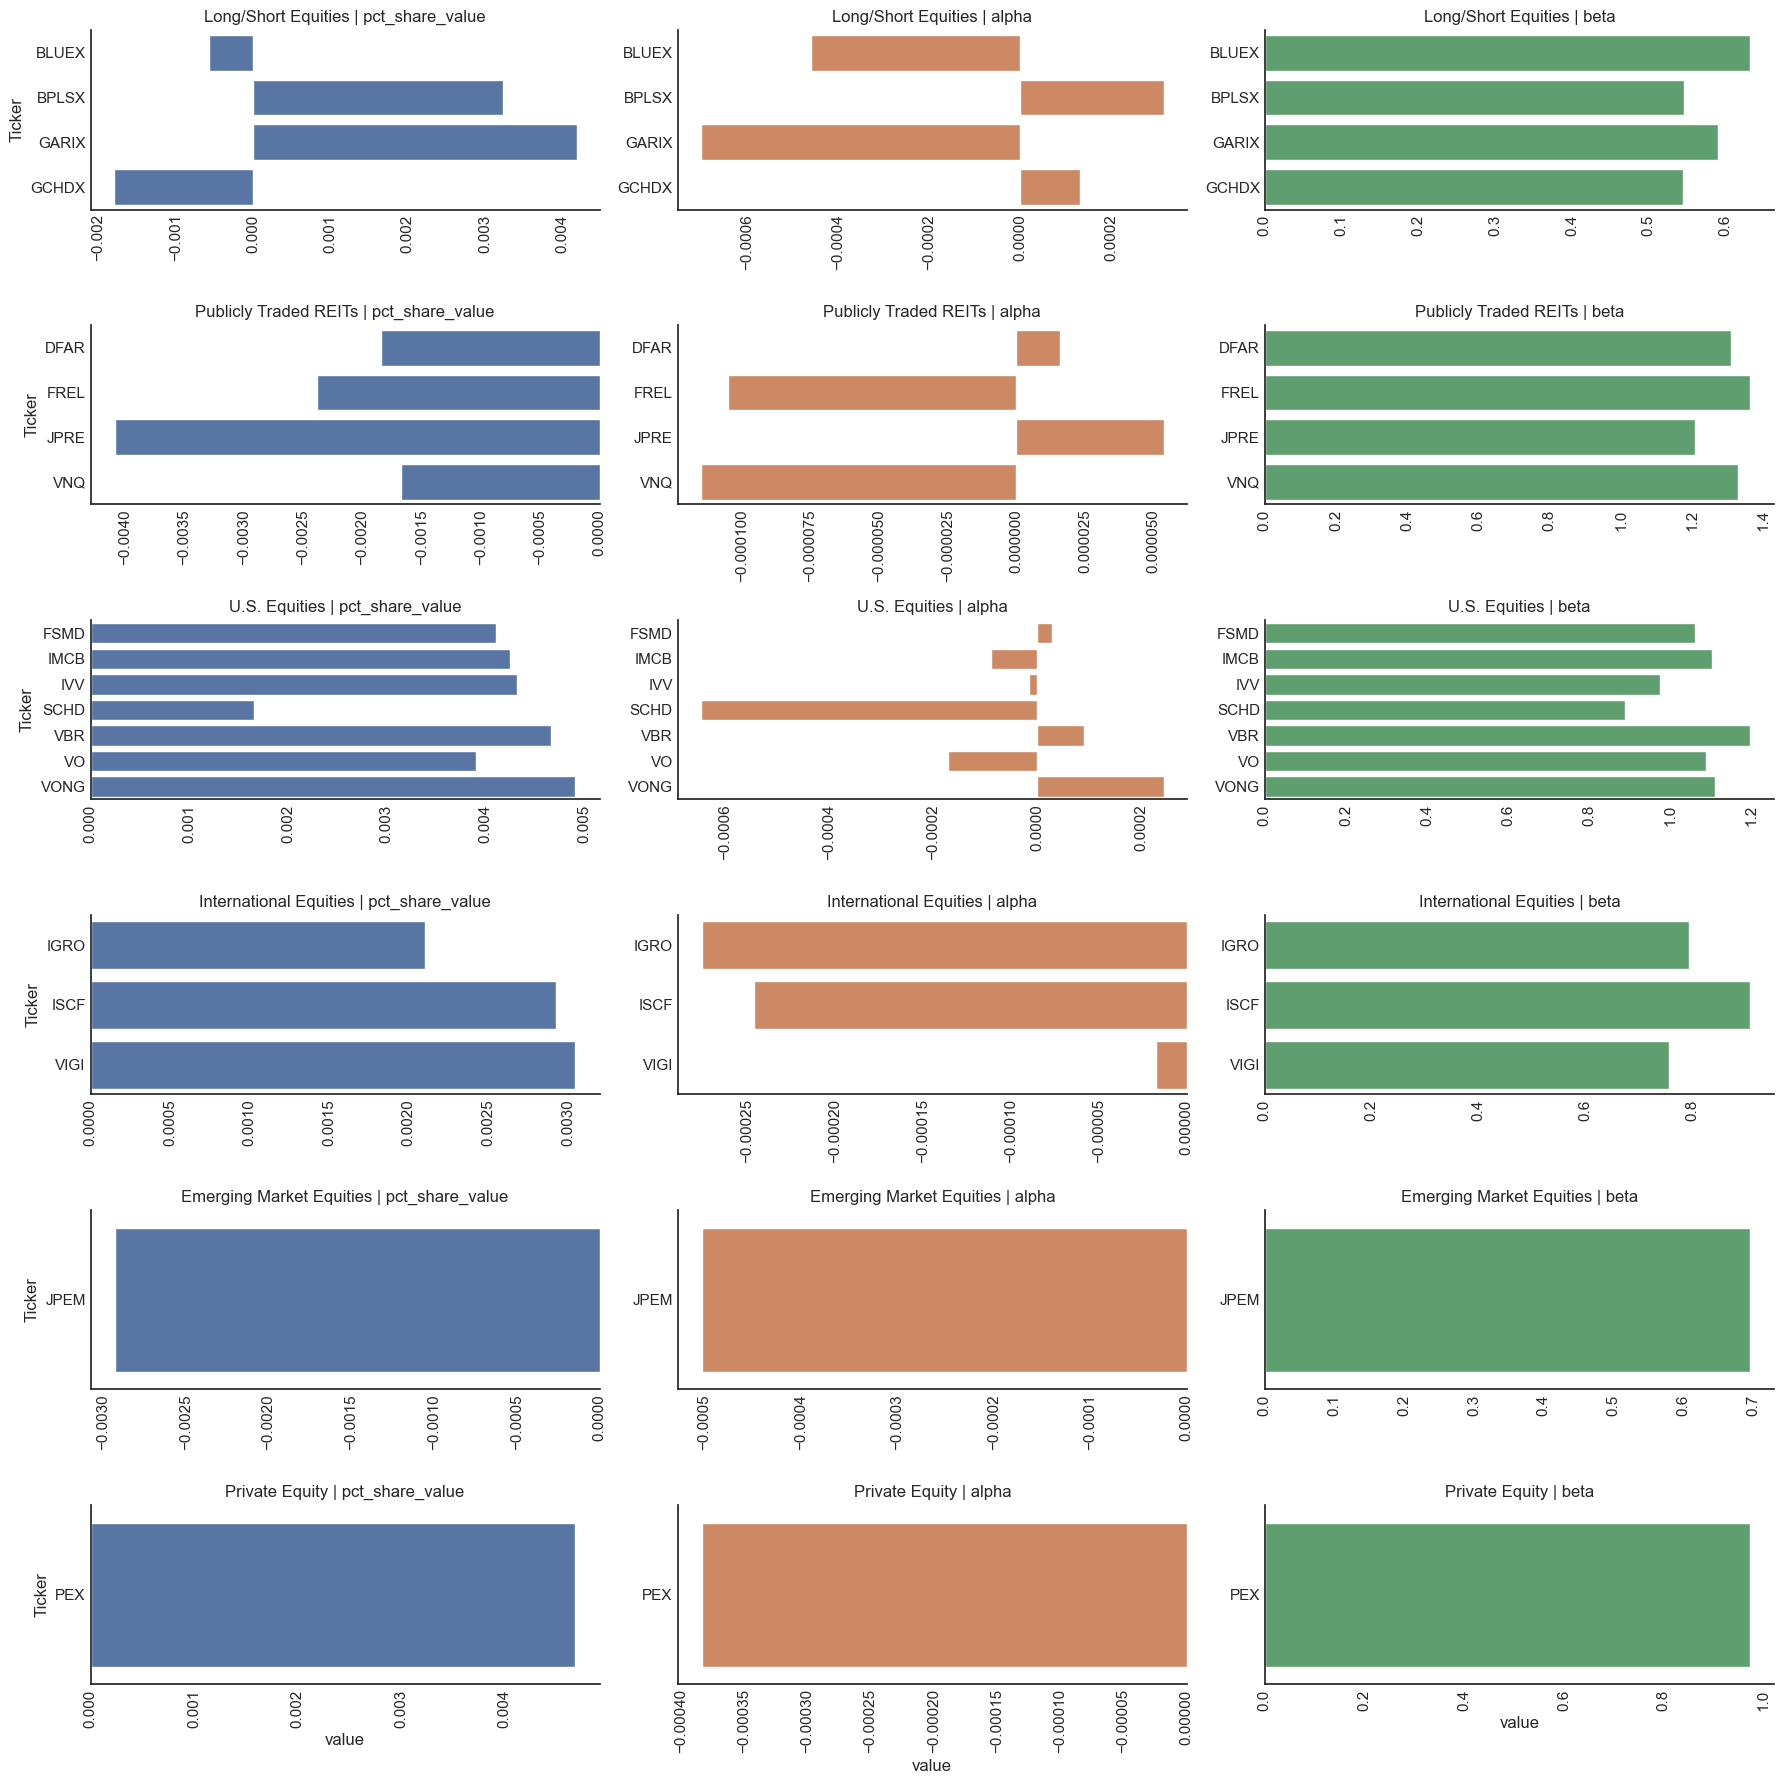

In [57]:
# Graph
g = sns.FacetGrid(long_df, col='variable', row = 'Sub_Class', hue='variable',
                  height=3, aspect=2, sharex=False, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.barplot, y="Ticker", x="value")

plt.show()

In [58]:
#FSMD
1000000 / 31.6200 

31625.553447185324

In [59]:
# IMCB
1000000 / 59.2600

16874.789065136687

In [60]:
1000000

1000000